<a href="https://colab.research.google.com/github/MJSahebnasi/temporal-network-platform/blob/main/thesis_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx

from typing import List, Type
import abc

import copy

import heapq

import time

# Events

## Model

In [ ]:
class Event:
  def __init__(self, t) -> None:
    self.time = t
    
  def __repr__(self):
    return "<time:" + str(self.time) + ">"

  # will be used in heap, when selecting the earliest event
  def __lt__(self, other):
    return self.time < other.time

  @abc.abstractmethod
  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    return

class NodeEvent(Event):
  def __init__(self, t, node) -> None:
    super().__init__(t)
    self.node = node

  def __repr__(self):
    return super().__repr__()[:-1] + "-node:"+str(self.node) + ">"

class NodeEntranceEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-entrance" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    ### intentionally won't handle this scenario:
    # if self.node in dead_and_attacked_nodes:
    #   return
    ###
    sim_G.add_node(self.node)
    edges = [(self.node, i) for i in _current_neighbors(sim_G, orig_G, self.node)]
    sim_G.add_edges_from(edges)

class NodeDeathEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-death" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    # might already be off or attacked
    if self.node in sim_G.nodes():
      sim_G.remove_node(self.node)
    # no matter the if, this must execute:
    dead_and_attacked_nodes.add(self.node)

class NodeAttackEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-attack" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    # might already be off or dead
    if self.node in sim_G.nodes():
      sim_G.remove_node(self.node)
    # no matter the if, this must execute:
    dead_and_attacked_nodes.add(self.node)

class NodeOnEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-on" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    # the node might die or get attacked while off
    if self.node in dead_and_attacked_nodes:
      return
    sim_G.add_node(self.node)
    edges = [(self.node, i) for i in _current_neighbors(sim_G, orig_G, self.node)]
    sim_G.add_edges_from(edges)

class NodeOffEvent(NodeEvent):
  def __init__(self, t, node) -> None:
    super().__init__(t, node)

  def __repr__(self):
    return super().__repr__()[:-1] + "-off" + ">"

  def execute(self, sim_G, orig_G, dead_and_attacked_nodes):
    # the node might be already dead or attacked
    # instead of using "dead_and_attacked_nodes", I used "nodes()"
    #   this way consecutive offs will be handled
    if self.node in sim_G.nodes():
      sim_G.remove_node(self.node)

def _current_neighbors(sim_G, orig_G, node):
  return set.intersection(set(sim_G.nodes()), set(orig_G.neighbors(node)))

# Snapshot

In [ ]:
class Snapshot():

  def __init__(self, t, G, dead_and_attacked_nodes):
    self.time = t
    self.G = G
    self.dead_and_attacked_nodes = dead_and_attacked_nodes

  def __repr__(self):
    return 'snapshot<t:'+str(self.time)+',G:'+str(self.G)+'>'

  # if a node is dead or attacked, the next two methods will result False for it
  
  def is_node_off(self, node):
    return (not G.has_node(node)) and (not node in self.dead_and_attacked_nodes)

  def is_node_on(self, node):
    return self.G.has_node(node)

# Simulation

In [ ]:
class Simulation:   

  ########################## init ##########################

  def create(self, G):
    self.orig_G = copy.deepcopy(G)
    self.sim_G = copy.deepcopy(G)
    self.dead_and_attacked_nodes = set() # not off nodes

    self.has_entrance_process = False
    self.has_onoff_process = False
    self.has_node_lifespan = False
    self.has_attack_process = False

    self.events = []
    
    self.snapshots = []
    self.snapshot_times = []

    return self

  def with_entrance_process(self, node_entrance_times):
    ### TODO: parameter validation ###
    self.has_entrance_process = True
    self.node_entrance_times = node_entrance_times
    return self

  def with_node_onoff_process(self, node_on_times, node_off_times):
    ### TODO: parameter validation ###
    self.has_onoff_process = True
    self.node_on_times = node_on_times
    self.node_off_times = node_off_times
    return self

  def with_node_lifespans(self, node_death_times):
    ### TODO: parameter validation ###
    self.has_node_lifespan = True
    self.node_death_times = node_death_times
    return self

  def with_attack_process(self, node_attack_times):
    """
    If you don't want a node to be attacked, just set a NEGATIVE attack time for it.
    example:
    [10, -1, -1, 13]
    The 2nd and the 3rd node will not be attacked.
    """
    ### TODO: parameter validation ###
    self.has_attack_process = True
    self.node_attack_times = node_attack_times
    return self


  ########################## input validation ##########################


  def __entrance_input_validation(self):
    if len(self.node_entrance_times) != self.orig_G.number_of_nodes():
      raise ValueError('!!! len(node_entrance_times) & the number of nodes not the same !!!')

  def __onoff_input_validation(self):
    n = self.orig_G.number_of_nodes()
    if len(self.node_on_times) != n:
      raise ValueError('!!! len(node_on_times) & the number of nodes not the same !!!')
    if len(self.node_off_times) != n:
      raise ValueError('!!! len(node_off_times) & the number of nodes not the same !!!')

  def __death_input_validation(self):
    if len(self.node_death_times) != self.orig_G.number_of_nodes():
      raise ValueError('!!! len(node_death_times) & the number of nodes not the same !!!')


  def __attack_input_validation(self):
    if len(self.node_attack_times) != self.orig_G.number_of_nodes():
      raise ValueError('!!! len(node_attack_times) & the number of nodes not the same !!!')


  ########################## prepair events ##########################


  def create_entrance_events(self):

    self.__entrance_input_validation()

    n = self.orig_G.number_of_nodes()
    nodes = list(self.orig_G.nodes())
    self.sim_G = nx.Graph()

    for i in range(n):
      node = nodes[i]
      e = NodeEntranceEvent(self.node_entrance_times[i], node)
      self.events.append(e)

  def create_onoff_events(self):

    self.__onoff_input_validation()

    n = self.orig_G.number_of_nodes()
    nodes = list(self.orig_G.nodes())

    for i in range(n):
      node = nodes[i]
      for t in self.node_on_times[i]:
        e = NodeOnEvent(t, node)
        self.events.append(e)
      for t in self.node_off_times[i]:
        e = NodeOffEvent(t, node)
        self.events.append(e)

  def create_death_events(self):

    self.__death_input_validation()

    n = self.orig_G.number_of_nodes()
    nodes = list(self.orig_G.nodes())

    for i in range(n):
      node = nodes[i]
      e = NodeDeathEvent(self.node_death_times[i], node)
      self.events.append(e)

  def create_attack_events(self):

    self.__attack_input_validation()

    n = self.orig_G.number_of_nodes()
    nodes = list(self.orig_G.nodes())

    for i in range(n):
      node = nodes[i]
      t = self.node_attack_times[i]

      if t < 0:
        continue

      e = NodeAttackEvent(t, node)
      self.events.append(e)

  def prepair_events(self):
    if self.has_entrance_process:
      self.create_entrance_events()

    if self.has_onoff_process:
      self.create_onoff_events()

    if self.has_node_lifespan:
      self.create_death_events()

    if self.has_attack_process:
      self.create_attack_events()

    heapq.heapify(self.events)


  ########################## run ##########################

  def take_snapshot(self):
    t = self.snapshot_times.pop()
    g = copy.deepcopy(self.sim_G)
    da = copy.deepcopy(self.dead_and_attacked_nodes)
    snp = Snapshot(t, g, da)
    self.snapshots.append(snp)

  def take_due_snapshots(self, time):
    while self.snapshot_times and self.snapshot_times[-1] < time: # cannot be <=
      self.take_snapshot()

  def run(self, snapshot_times=[]):
    """
    snapshot_times: optional arg
      if provided, must be a sorted (ascending) list of times (could be float or int)
      times greater than the simulation duration will be ignored
    """

    if snapshot_times:
      self.snapshot_times = copy.deepcopy(snapshot_times)
      self.snapshot_times.reverse() # so that we can just pop the smallest time, no shift

    self.prepair_events()

    sim_time = 0
    
    while len(self.events) > 0:

      e = heapq.heappop(self.events)

      if e.time > sim_time:
        if self.snapshot_times:
          self.take_due_snapshots(e.time)

      e.execute(self.sim_G, self.orig_G, self.dead_and_attacked_nodes)

      sim_time = e.time

    # taking the remaining snapshots, after the last event (with the final self.sim_G)
    for i in range(len(self.snapshot_times)):
      self.take_snapshot()
    
    return self.sim_G, self.snapshots

In [ ]:
# has good things in it
# like death after attack
G = nx.erdos_renyi_graph(n=3,p=0.7)
ent = [0, 1, 2]
dth = [10, 50, 55]
atk = [8.5, -1, -1]
off = [[3], [10, 20], []]
on  = [[5], [12.5], []]

snp_t = [0, 1, 2, 4, 5, 6.5, 54, 55, 56]

s = Simulation().create(G).with_entrance_process(ent).with_node_lifespans(dth).with_attack_process(atk).with_node_onoff_process(on, off)
res, snaps = s.run(snapshot_times = snp_t)

In [ ]:
# print('in:')
# print(G)
# print(G.nodes())
# print(G.edges())
# print('*********')
# print('res:')
# print(res)
# print(res.nodes())
# print(res.edges())
# print('*********')
# print(len(snaps))
# print(len(snp_t))
# print('*********')
# for i in range(len(snaps)):
#   g = snaps[i].G
#   t = snp_t[i]
#   print(i)
#   print('t:', t)
#   print(g)
#   print(g.nodes())
#   print(g.edges())
#   print('-------')

# print(snaps)

# Diagram Package

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_degree_distribution(G, diagram_title=''):
  degree_distrib = nx.degree_histogram(G)
  x = range(len(degree_distrib))

  plt.figure(figsize=(12, 8))

  plt.plot(x, degree_distrib, marker='o')
  cnct = ' - ' if len(diagram_title) > 0 else ''
  title = 'degree distribution' + cnct + diagram_title
  plt.title(title)
  plt.grid()
  plt.xticks(x, fontsize=10)
  plt.yticks(np.arange(np.min(degree_distrib), np.max(degree_distrib) + 1, 1), fontsize=9)
  plt.xlabel('degree')
  plt.ylabel('nodes count')
  plt.tick_params(labelrotation=45)

  plt.show()


def plot_onoff_graph(G, node_colors, edge_colors):
  plt.figure()
  nx.draw_circular(G, node_color=node_colors, edge_color=edge_colors)

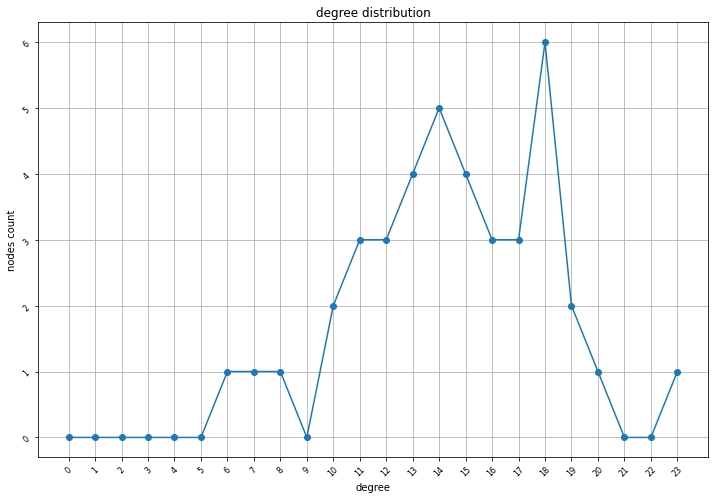

In [ ]:
plot_degree_distribution(nx.erdos_renyi_graph(40, 0.4))
# plot_onoff_graph(G, G)

# Data Generator Package

In [ ]:
import math
import random

In [ ]:
def poisson_process(landa, max_time):
  """
  returns a list of numbers (times, float) based on Poisson Process
  landa: exponential distribution's parameter
  max_time: the SUM of the times in the returned list will not exceed max_time
  """
  res = []
  sum = 0
  while True:
    x = random.expovariate(landa)
    new_sum = sum + x
    if new_sum <= max_time:
      res.append(x)
      sum = new_sum
    else:
      break
  return res

In [ ]:
# test
r = poisson_process(0.005, 1000)
print(r)
print('sum:', sum(r))

[16.08861545102149, 302.2068273593911, 117.6040938507552, 374.3379693833301]
sum: 810.2375060444979


In [ ]:
def onoff_data_generator(on_durations, off_durations, start_time=0, max_time=math.inf):
  """
  input:
    example:
    1. on_durations = [ [3, 4], [10] ]
      -> node0 has 2 <on periods>, which last 3 and 4 time units
      -> node1 has 1 <on period>, which lasts 10 time units
    2. off_durations is the same
    ### both on_durations and off_durations must have the same length
    3. start_time: on/off durations will be added to this (events will happen after this time)
    4. max_time: on/off event times will not exceed max_time (remaining on/off durations will be ignored)
  how it works:
    I assume all nodes are <on> first.
    For each node, takes the first <on> duration, so the end of it will be the first <off> event's time;
    then adds the first <off duration> to the time, which gives us the first <on> event's time. And keeps
    doing this until we run out of either <on duration>s or <off duration>s.
  retuens:
    on_times: times a node becomes online, for each node
    off_times: times a node becomes offline, for each node
     -> the same format that with_onoff_process() requires
    example:
    on_times= [[1,3,4], []]
    off_times = [[2,3.5], [1]]
      -> node0 events: 1:on, 2:off, 3:on, 3.5:off, 4:on
      -> node1 events: 1:off
  """

  if len(on_durations) != len(off_durations):
    raise ValueError('!!! len(on_durations) and len(off_durations) must be the same !!!')
  
  n = len(on_durations)

  on_times = [[] for i in range(n)]
  off_times = [[] for i in range(n)]

  for node_id in range(n):
    i_on = 0
    i_off = 0
    t = start_time
    while True:
      if i_on < len(on_durations[node_id]):
        off_event_time = t + on_durations[node_id][i_on]
        if off_event_time < max_time:
          off_times[node_id].append(off_event_time)
          t = off_event_time
          i_on += 1
        else:
          off_times[node_id].append(max_time)
          break
      else:
        break
      if i_off < len(off_durations[node_id]):
        on_event_time = t + off_durations[node_id][i_off]
        if off_event_time < max_time:
          on_times[node_id].append(on_event_time)
          t = on_event_time
          i_off += 1
        else:
          on_times[node_id].append(max_time)
          break
      else:
        break
  
  return on_times, off_times

In [ ]:
# test
on_d = [[1, 1, 0.5, 2], [2, 0], [1]]
of_d = [[1, 3],         [1, 1, 2], []]

# node0: 1:off, 2:on, 3:off, 6:on, 6.5:off
# node1: 2:off, 3:on, 3:off, 4:on
# node2: 1:off

on_t, of_t = onoff_data_generator(on_d, of_d)
print('on:', on_t)
print('off:', of_t)

on: [[2, 6], [3, 4], []]
off: [[1, 3, 6.5], [2, 3], [1]]


In [ ]:
from scipy.stats import pareto
from itertools import accumulate

def selfsimular_traffic_generator(number_of_bursts, on_pareto_shape, off_pareto_shape):
  """
  Parameters:
  There are On periods, in which bursts occur. The number of packets generated in each burst follows a Pareto distribution. 
  The parameter of this distribution are on_pareto_shape (or alpha). The scale (or x_m) is set to 1.

  number_of_bursts is the same as the number of On periods.

  There are also Off periods, in which no packet is generated. The length of these periods also follows a Pareto distribution.

  returns:
  a list of times (each corresponding to a packet burst)
  and a list of packet_counts (number of packets in each burst)
  """
  float_packet_counts = pareto.rvs(on_pareto_shape, size = number_of_bursts)
  packet_counts = [int(i) for i in float_packet_counts]
  
  raw_times = pareto.rvs(off_pareto_shape, size = number_of_bursts - 1)
  times = [0] + list(accumulate(raw_times))

  return packet_counts, times

# Model's Diagrams

## diagram A

In [ ]:
def OnOFF_Scenario_A(G, snp_t, sim_duration, landa, mue):

  n = G.number_of_nodes()

  on_durations = [poisson_process(mue, sim_duration) for i in range(n)]
  off_durations = [poisson_process(landa, sim_duration) for i in range(n)]

  on_t, off_t = onoff_data_generator(on_durations, off_durations, max_time=sim_duration)

  s = Simulation().create(G).with_node_onoff_process(on_t, off_t)
  res, snaps = s.run(snapshot_times = snp_t)

  # if we had other processes, this would not work
  # (some nodes might be attacked or dead)
  for s in range(len(snaps)):
    sim_G = snaps[s].G
    on_nodes = set(sim_G.nodes())
    node_colors = [None for j in range(n)]
    edge_colors = [None for j in range(G.number_of_edges())]
    edges = list(G.edges())
    on_cnt = 0
    for i in range(G.number_of_edges()):
      (n1, n2) = edges[i]
      n1_on = False
      n2_on = False
      if node_colors[n1] == 'red':
        n1_on = True
      elif node_colors[n1] == 'grey':
        # n1_on = False
        pass
      else:
        if n1 in on_nodes:
          node_colors[n1] = 'red'
          n1_on = True
          on_cnt += 1
        else:
          node_colors[n1] = 'grey'

      if node_colors[n2] == 'red':
        n2_on = True
      elif node_colors[n2] == 'grey':
        # n2_on = False
        pass
      else:
        if n2 in on_nodes:
          node_colors[n2] = 'red'
          n2_on = True
          on_cnt += 1
        else:
          node_colors[n2] = 'grey'
      
      if n1_on and n2_on:
        edge_colors[i] = 'red'
      else:
        edge_colors[i] = 'grey'
    
    # remaining (isolated) nodes
    for c in node_colors:
      if not c:
        c = 'grey'

    print('snapshot', s,'- online nodes ratio:', on_cnt/n)

    plot_onoff_graph(G, node_colors, edge_colors)

In [ ]:
import time

n = 100
k = 10 
p = 0.3

G_SW_A = nx.watts_strogatz_graph(n, k, p)

landa = 0.005 # based on the paper, this is used for OFF duration (not on)
mue_1 = 0.005
mue_2 = 0.01

snp_times_A = [2*10**3, 4*10**3, 6*10**3, 8*10**3, 10**4]


snapshot 0 - online nodes ratio: 0.43
snapshot 1 - online nodes ratio: 0.44
snapshot 2 - online nodes ratio: 0.59
snapshot 3 - online nodes ratio: 0.52
snapshot 4 - online nodes ratio: 0.53
execution time: 0.7948639392852783


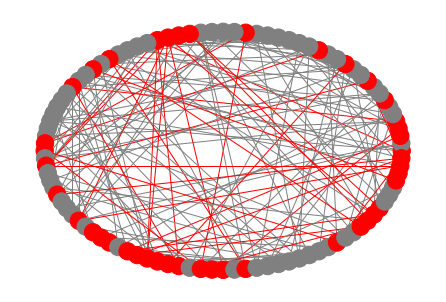

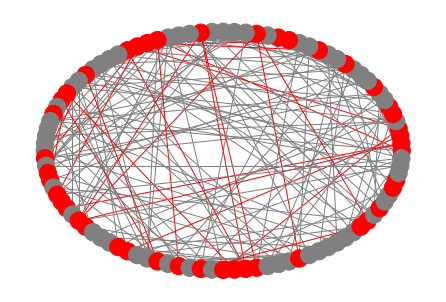

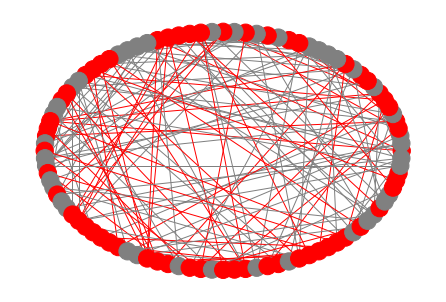

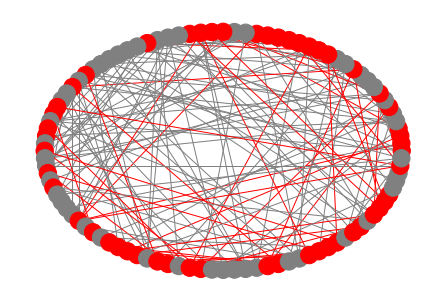

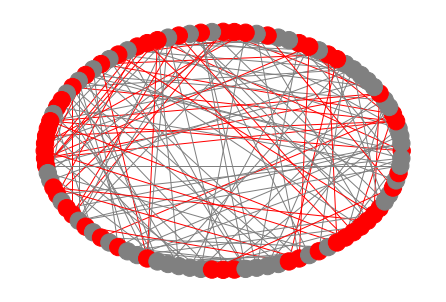

In [ ]:
t_a1 = time.time()
OnOFF_Scenario_A(G_SW_A, snp_times_A, 10**4+100, landa, mue_1)
t_a2 = time.time()
print('execution time:', t_a2 - t_a1)

snapshot 0 - online nodes ratio: 0.31
snapshot 1 - online nodes ratio: 0.38
snapshot 2 - online nodes ratio: 0.29
snapshot 3 - online nodes ratio: 0.28
snapshot 4 - online nodes ratio: 0.29
execution time: 0.2896308898925781


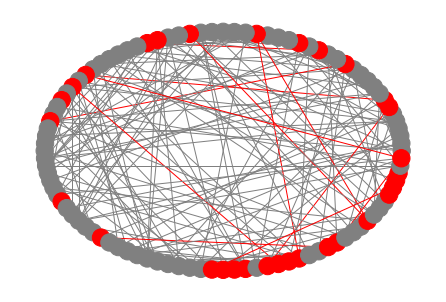

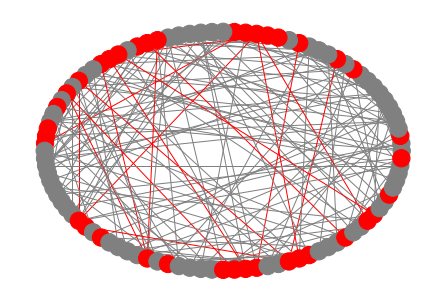

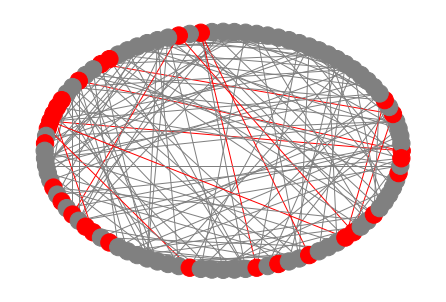

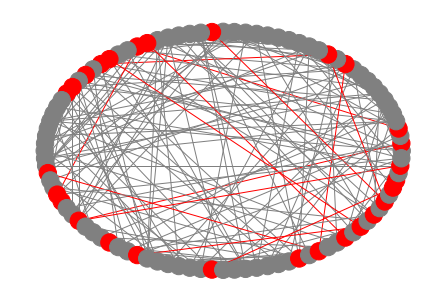

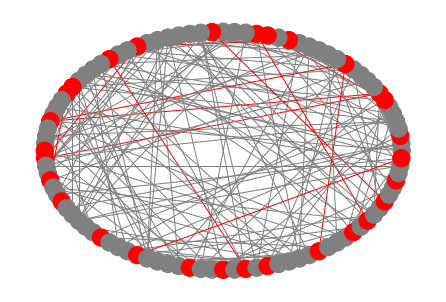

In [ ]:
t_a1 = time.time()
OnOFF_Scenario_A(G_SW_A, snp_times_A, 10**4+100, landa, mue_2)
t_a2 = time.time()
print('execution time:', t_a2 - t_a1)

## diagram B

In [ ]:
def B(G, snp_t, sim_duration, landa, mue):
  n = G.number_of_nodes()

  on_durations = [poisson_process(mue, sim_duration) for i in range(n)]
  off_durations = [poisson_process(landa, sim_duration) for i in range(n)]

  on_t, off_t = onoff_data_generator(on_durations, off_durations, max_time=sim_duration)

  s = Simulation().create(G).with_node_onoff_process(on_t, off_t)
  res, snaps = s.run(snapshot_times = snp_t)

  online_neighbors = [[] for i in range(n)]
  avrg_online_neighbors = []
  all_nodes = list(G.nodes())
  for s in snaps:
    sum_on_neighs = 0
    for i in range(n): # all nodes not the ones in the sim_G
      node = all_nodes[i]
      on_neighs = 0
      for neigh in list(G.neighbors(node)):
        if s.is_node_on(neigh):
          on_neighs += 1
      online_neighbors[i].append(on_neighs)
      sum_on_neighs += on_neighs
    avrg_online_neighbors.append(sum_on_neighs/n)

  return online_neighbors, avrg_online_neighbors


In [ ]:
def onoff_scenario_B(G, snp_t, sim_duration, landa, mue):

  plt.figure()

  data, avr = B(G, snp_t, sim_duration, landa, mue)
  x = snp_t
  for y in data:
    plt.plot(x, y, color='c', alpha=0.6)
    title = 'online neighbors & time'
    plt.title(title)
    # plt.grid()
    plt.xticks(x)
    # plt.yticks(np.arange(0, 200, 1))
    plt.xlabel('t')
    plt.ylabel('size')
    plt.xscale("log")

  plt.plot(x, avr, color='black')
  # # plt.grid()
  # plt.xticks(x)
  # # plt.yticks(np.arange(0, 200, 1))
  # plt.xlabel('t')
  # plt.ylabel('size')
  # plt.tick_params(labelrotation=45)
  # plt.xscale("log")
  # # plt.legend('k')

  plt.show()

  print('<k> =', np.mean(np.array(avr[-20:])))

In [ ]:
n_B = 2000
sim_dur_B = 1000

G_SF_B = nx.barabasi_albert_graph(n_B, m=5)

G_SW_B = nx.watts_strogatz_graph(n_B, k=20, p=0.3)

landa_B = 0.01

mue1_B = 0.005
mue2_B = 0.01
mue3_B = 0.015

snp_times_b = [0, 0.1, 1, 5, 10]+[i*20 for i in range(1,51)]

print(snp_times_b)

[0, 0.1, 1, 5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000]


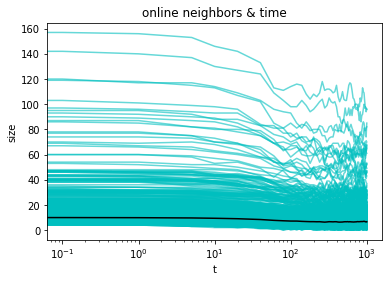

<k> = 6.727199999999999
execution time: 31.416496515274048


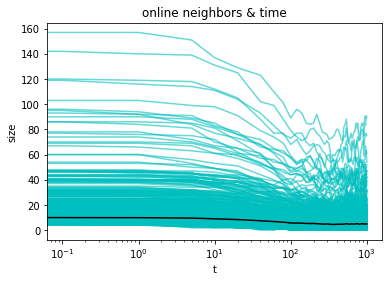

<k> = 4.8778999999999995


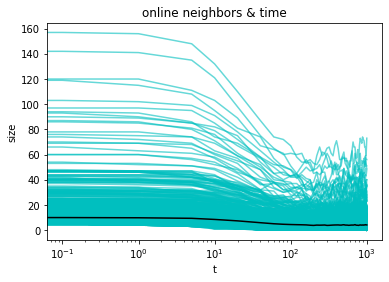

<k> = 4.157400000000001


In [ ]:
t_a1 = time.time()
onoff_scenario_B(G_SF_B, snp_times_b, sim_dur_B+100, landa_B, mue1_B)
t_a2 = time.time()
print('execution time:', t_a2 - t_a1)

onoff_scenario_B(G_SF_B, snp_times_b, sim_dur_B+100, landa_B, mue2_B)
onoff_scenario_B(G_SF_B, snp_times_b, sim_dur_B+100, landa_B, mue3_B)

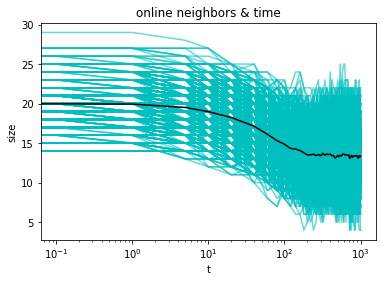

<k> = 13.3589


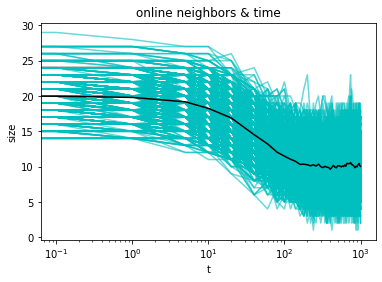

<k> = 10.215074999999999


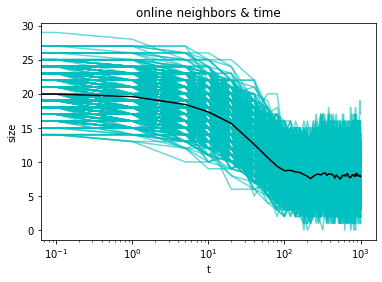

<k> = 8.013375000000002


In [ ]:
onoff_scenario_B(G_SW_B, snp_times_b, sim_dur_B+100, landa_B, mue1_B)
onoff_scenario_B(G_SW_B, snp_times_b, sim_dur_B+100, landa_B, mue2_B)
onoff_scenario_B(G_SW_B, snp_times_b, sim_dur_B+100, landa_B, mue3_B)

## diagram C

In [ ]:
n1 = 2000
n2 = 4000
n3 = 6000
k = 10 
p = 0.3

G_SW_1 = nx.watts_strogatz_graph(n1, k, p)
G_SW_2 = nx.watts_strogatz_graph(n2, k, p)
G_SW_3 = nx.watts_strogatz_graph(n3, k, p)

landa1 = 0.01
landa2 = 0.02

mue_1 = 0.005
mue_2 = 0.01
mue_3 = 0.015

snp_times_c = [0, 0.1, 5, 10, 50, 100]+[i*200 for i in range(1,51)]

print(snp_times_c)

[0, 0.1, 5, 10, 50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800, 6000, 6200, 6400, 6600, 6800, 7000, 7200, 7400, 7600, 7800, 8000, 8200, 8400, 8600, 8800, 9000, 9200, 9400, 9600, 9800, 10000]


In [ ]:
def c(G, snp_t, sim_duration, landa, mue):
  n = G.number_of_nodes()

  on_durations = [poisson_process(mue, sim_duration) for i in range(n)]
  off_durations = [poisson_process(landa, sim_duration) for i in range(n)]

  on_t, off_t = onoff_data_generator(on_durations, off_durations, max_time=sim_duration)

  s = Simulation().create(G).with_node_onoff_process(on_t, off_t)
  res, snaps = s.run(snapshot_times = snp_t)

  sizes = []
  for s in snaps:
    g = s.G
    sizes.append(g.number_of_nodes())

  return sizes

In [ ]:
def onoff_scenario_C(G_list, snp_t, sim_duration, landa, mue):

  plt.figure()

  for G in G_list:
    y = c(G, snp_t, sim_duration, landa, mue)
    x = snp_t

    plt.plot(x, y)
    title = 'network sizes & time'
    plt.title(title)
    # plt.grid()
    plt.xticks(x)
    # plt.yticks(np.arange(np.min(y)-500, np.max(y) + 100, 1))
    plt.xlabel('t')
    plt.ylabel('size')
    plt.tick_params(labelrotation=45)

    plt.xscale("log")

  plt.show()

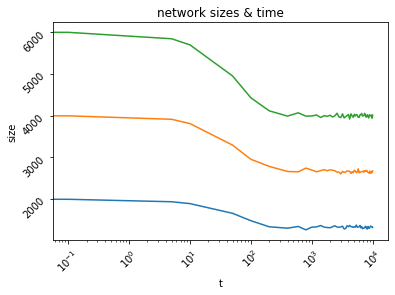

execution time: 100.46942210197449


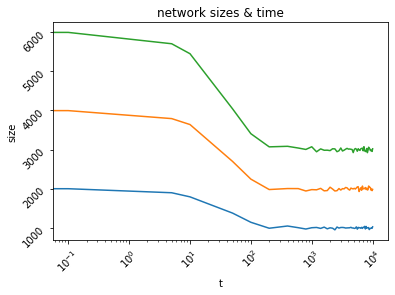

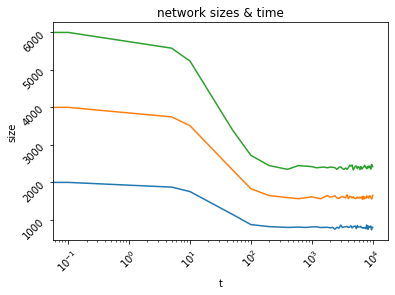

In [ ]:
t_a1 = time.time()
onoff_scenario_C([G_SW_1, G_SW_2, G_SW_3], snp_times_c, 10**4+100, landa1, mue_1)
t_a2 = time.time()
print('execution time:', t_a2 - t_a1)

onoff_scenario_C([G_SW_1, G_SW_2, G_SW_3], snp_times_c, 10**4+100, landa1, mue_2)
onoff_scenario_C([G_SW_1, G_SW_2, G_SW_3], snp_times_c, 10**4+100, landa1, mue_3)

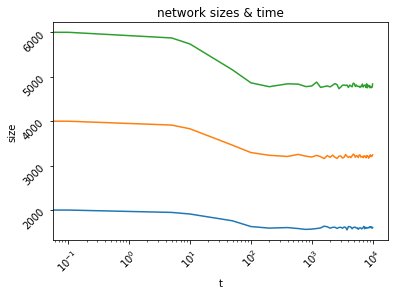

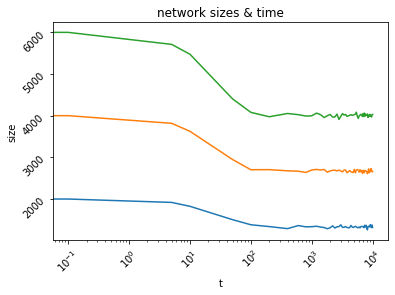

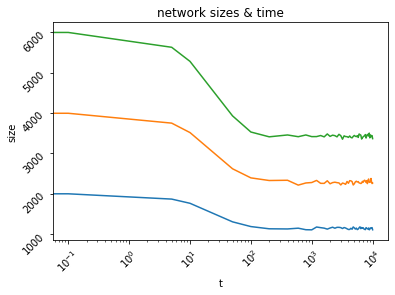

In [ ]:
onoff_scenario_C([G_SW_1, G_SW_2, G_SW_3], snp_times_c, 10**4+100, landa2, mue_1)
onoff_scenario_C([G_SW_1, G_SW_2, G_SW_3], snp_times_c, 10**4+100, landa2, mue_2)
onoff_scenario_C([G_SW_1, G_SW_2, G_SW_3], snp_times_c, 10**4+100, landa2, mue_3)

## diagram D

In [ ]:
n = 1000

m = 10

G_SF_1 = nx.barabasi_albert_graph(n, m)

landa1 = 0.005
landa2 = 0.01
landa3 = 0.015

mue_1 = 0.005
mue_2 = 0.01
mue_3 = 0.015

snp_times_d = [12000, 15000, 18000]

In [ ]:
def D(G, snp_t, sim_duration, landa, mue):
  n = G.number_of_nodes()

  on_durations = [poisson_process(mue, sim_duration) for i in range(n)]
  off_durations = [poisson_process(landa, sim_duration) for i in range(n)]

  on_t, off_t = onoff_data_generator(on_durations, off_durations, max_time=sim_duration)

  s = Simulation().create(G).with_node_onoff_process(on_t, off_t)
  res, snaps = s.run(snapshot_times = snp_t)

  # return np.mean([s.G.number_of_nodes() for s in snaps])
  return snaps[0].G.number_of_nodes()

In [ ]:
def onoff_scenario_D(G, snp_t, sim_duration, landa, mues, samples):

  fig, ax = plt.subplots(1,1)
  fig.tight_layout()
  fig.set_size_inches(10, 7)
  fig.suptitle('size & mue & landa')
  fig.subplots_adjust(top=0.93)

  # ax[i].set_title('lambda:'+str(landa))
  ax.set_title('lambda:'+str(landa))
  # ax[i].set_xlabel('mue')
  ax.set_xlabel('N')
  # ax[i].set_ylabel('N')
  ax.set_ylabel('p')

  colors = ['red','green','blue']

  for m in range(len(mues)):
    mue = mues[m]
    ys = []
    for i in range(samples):
      y = E(G, snp_t, sim_duration, landa, mue)
      ys.append(y)
    x = list(set(ys))
    cnts = [ys.count(y) for y in x]
    s_cnts = sum(cnts)
    cnts = [c/s_cnts for c in cnts]

    ax.scatter(x, cnts, color=colors[m])

execution time: 677.7553308010101


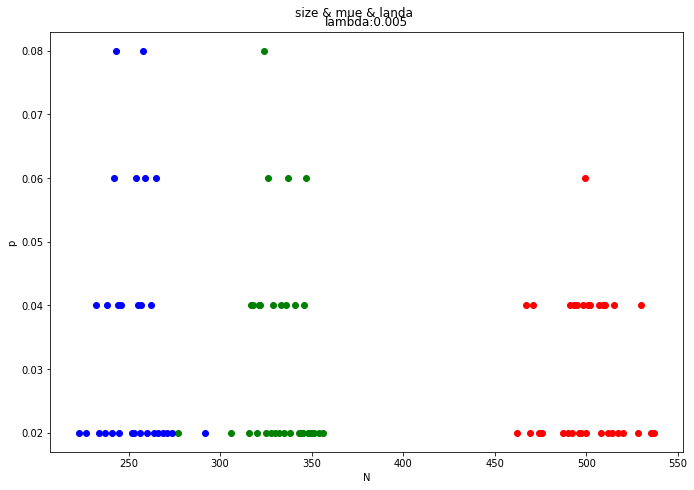

In [ ]:
t_a1 = time.time()
# onoff_scenario_D(G_SF_1, snp_times_d, 18000, landa1, [mue_1, mue_2, mue_3], 50)
onoff_scenario_D(G_SF_1, [17000], 18000, landa1, [mue_1, mue_2, mue_3], 50)
t_a2 = time.time()
print('execution time:', t_a2 - t_a1)

## diagram E

In [ ]:
n1 = 2000
n2 = 4000
n3 = 6000

m = 10

G_SF_1 = nx.barabasi_albert_graph(n1, m)
G_SF_2 = nx.barabasi_albert_graph(n2, m)
G_SF_3 = nx.barabasi_albert_graph(n3, m)

landa1 = 0.005
landa2 = 0.01
landa3 = 0.015

mues = [0.05*i for i in range(1,7)]

# snp_times_e = [20000 + i*140*1000 for i in range(1,8)]
snp_times_e = [10000 + i*2000 for i in range(6)]

print(mues)
print(snp_times_e)

[0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004]
[10000, 12000, 14000, 16000, 18000, 20000]


In [ ]:
def E(G, snp_t, sim_duration, landa, mue):
  n = G.number_of_nodes()

  on_durations = [poisson_process(mue, sim_duration) for i in range(n)]
  off_durations = [poisson_process(landa, sim_duration) for i in range(n)]

  on_t, off_t = onoff_data_generator(on_durations, off_durations, max_time=sim_duration)

  s = Simulation().create(G).with_node_onoff_process(on_t, off_t)
  res, snaps = s.run(snapshot_times = snp_t)

  return np.mean([s.G.number_of_nodes() for s in snaps])

In [ ]:
def onoff_scenario_E(G_list, snp_t, sim_duration, landa_list, mue_list):

  fig, ax = plt.subplots(1,len(landa_list))
  fig.tight_layout()
  fig.set_size_inches(10*len(landa_list), 7)
  fig.suptitle('size & mue')
  fig.subplots_adjust(top=0.93)

  colors = ['red','green','blue']

  for i in range(len(landa_list)):

    landa = landa_list[i]

    # ax[i].set_title('lambda:'+str(landa))
    ax.set_title('lambda:'+str(landa))
    # ax[i].set_xlabel('mue')
    ax.set_xlabel('mue')
    # ax[i].set_ylabel('N')
    ax.set_ylabel('N')

    for g in range(len(G_list)):
      G = G_list[g]

      for mue in mue_list:        
        y = E(G, snp_t, sim_duration, landa, mue)
        # ax[i].scatter(mue, y, color=colors[g])
        ax.scatter(mue, y, color=colors[g])

execution time: 614.4725024700165


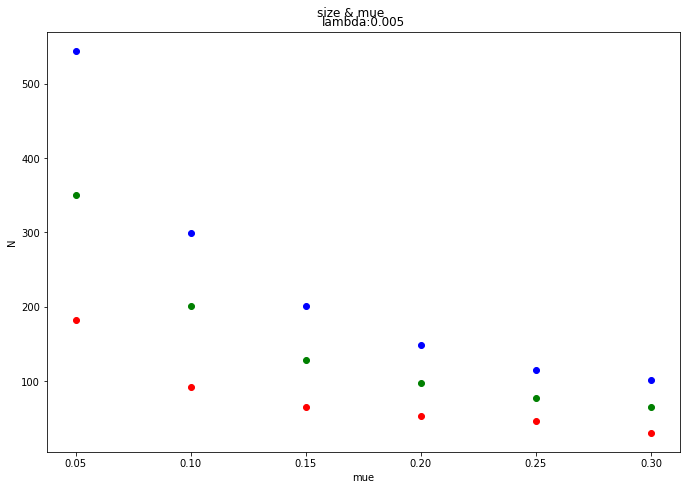

In [ ]:
t_a1 = time.time()
onoff_scenario_E([G_SF_1, G_SF_2, G_SF_3], snp_times_e, 2*10**4+100, [landa1], mues)
t_a2 = time.time()
print('execution time:', t_a2 - t_a1)

execution time: 1113.99289560318


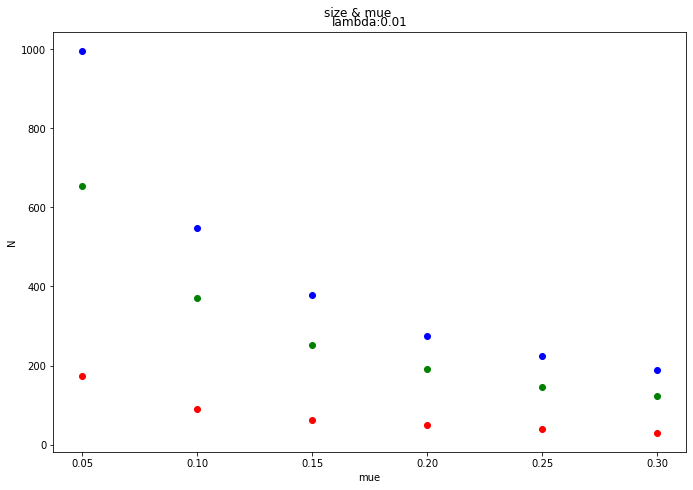

In [ ]:
t_a1 = time.time()
onoff_scenario_E([G_SF_1, G_SF_2, G_SF_3], snp_times_e, 2*10**4+100, [landa2], mues)
t_a2 = time.time()
print('execution time:', t_a2 - t_a1)

In [ ]:
t_a1 = time.time()
onoff_scenario_E([G_SF_1, G_SF_2, G_SF_3], snp_times_e, 2*10**4+100, [landa3], mues)
t_a2 = time.time()
print('execution time:', t_a2 - t_a1)

## diagram F

In [ ]:
n_f = 2000

k1 = 20
k2 = 40
k3 = 60

p = 0.2

G_SW_1 = nx.watts_strogatz_graph(n_f, k1, p)
G_SW_2 = nx.watts_strogatz_graph(n_f, k2, p)
G_SW_3 = nx.watts_strogatz_graph(n_f, k3, p)

m1 = 5
m2 = 10
m3 = 20

G_SF_1 = nx.barabasi_albert_graph(n_f, m1)
G_SF_2 = nx.barabasi_albert_graph(n_f, m2)
G_SF_3 = nx.barabasi_albert_graph(n_f, m3)

landa1 = 0.01
landa2 = 0.02

mue_1 = 0.005
mue_2 = 0.01
mue_3 = 0.015

snp_times_f = [10**4 + i*200 for i in range(0,51)]

print(snp_times_f)

[10000, 10200, 10400, 10600, 10800, 11000, 11200, 11400, 11600, 11800, 12000, 12200, 12400, 12600, 12800, 13000, 13200, 13400, 13600, 13800, 14000, 14200, 14400, 14600, 14800, 15000, 15200, 15400, 15600, 15800, 16000, 16200, 16400, 16600, 16800, 17000, 17200, 17400, 17600, 17800, 18000, 18200, 18400, 18600, 18800, 19000, 19200, 19400, 19600, 19800, 20000]


In [ ]:
def F(G, snp_t, sim_duration, landa, mue):
  n = G.number_of_nodes()

  on_durations = [poisson_process(mue, sim_duration) for i in range(n)]
  off_durations = [poisson_process(landa, sim_duration) for i in range(n)]

  on_t, off_t = onoff_data_generator(on_durations, off_durations, max_time=sim_duration)

  s = Simulation().create(G).with_node_onoff_process(on_t, off_t)
  res, snaps = s.run(snapshot_times = snp_t)

  return [nx.degree_histogram(s.G) for s in snaps]

In [ ]:
def onoff_scenario_F(G_list, snp_t, sim_duration, landa, mue_list):

  fig, ax = plt.subplots(1,3)
  fig.tight_layout()
  fig.set_size_inches(30, 7)
  fig.suptitle('degree distributions')
  fig.subplots_adjust(top=0.93)

  ms = [5,10,20]
  colors = ['red','blue','green']
  # markers = ['o', ]

  max_x = 71 # based on the paper
  x = range(max_x)

  for i in range(len(mue_list)):
    mue = mue_list[i]

    ax[i].legend(loc='top right')
    # ax[g].tick_params(labelrotation=45)
    ax[i].set_title('lambda:'+str(landa)+' , mue:'+str(mue))
    # ax[g].grid()
    # ax[g].set_xticks(failure_p_values)
    ax[i].set_xlabel('k')
    ax[i].set_ylabel('p(k)')
    # ax[0].set_yticks(np.linspace(0, 1, num=11))  ### not beautiful

    for g in range(len(G_list)):
      G = G_list[g]
      ys = F(G, snp_t, sim_duration, landa, mue)
      once = False
      for y in ys:
        # sy = np.sum(y)
        sy = sum(y)
        # p_y = np.array(y[:max_x])/sy
        p_y = [v/sy for v in y[:max_x]]
        if len(p_y) < max_x:
          # np.concatenate([p_y, np.zeros()])
          p_y = p_y + [0 for i in range(max_x - len(p_y))]
        if not once:
          # ax[i].scatter(x, p_y, label = 'm='+str(ms[g]), color=colors[g], marker='o', alpha=0.6)
          ax[i].plot(x, p_y, label = 'm='+str(ms[g]), color=colors[g], alpha=0.3)
          once = True
        else:
          # ax[g].scatter(x, p_y, color=colors[g], marker='o', alpha=0.6)
          ax[i].plot(x, p_y, label = 'm='+str(ms[g]), color=colors[g], alpha=0.3)

<ipython-input-248-5615892cde98>:19: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  ax[i].legend(loc='top right')


execution time: 232.5414171218872


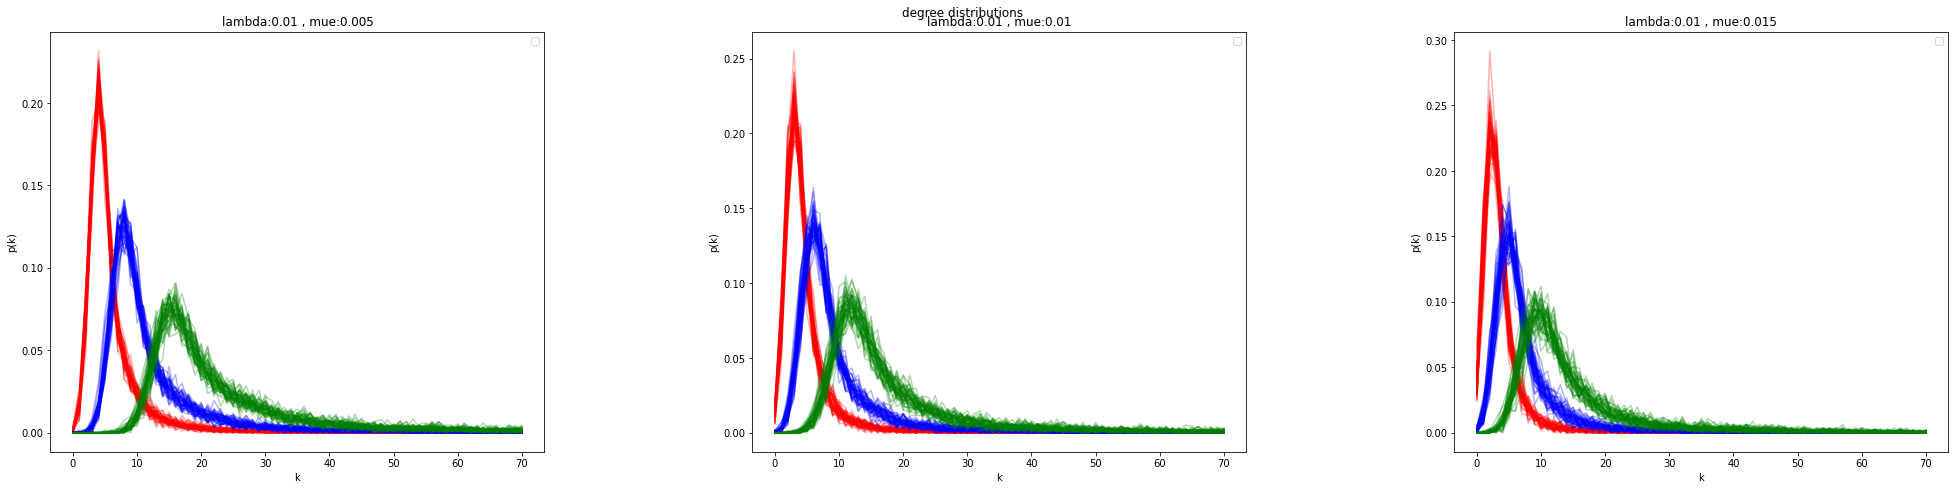

In [ ]:
t_a1 = time.time()
onoff_scenario_F([G_SF_1, G_SF_2, G_SF_3], snp_times_f, 2*10**4+100, landa1, [mue_1, mue_2, mue_3])
t_a2 = time.time()
print('execution time:', t_a2 - t_a1)

<ipython-input-248-5615892cde98>:19: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  ax[i].legend(loc='top right')


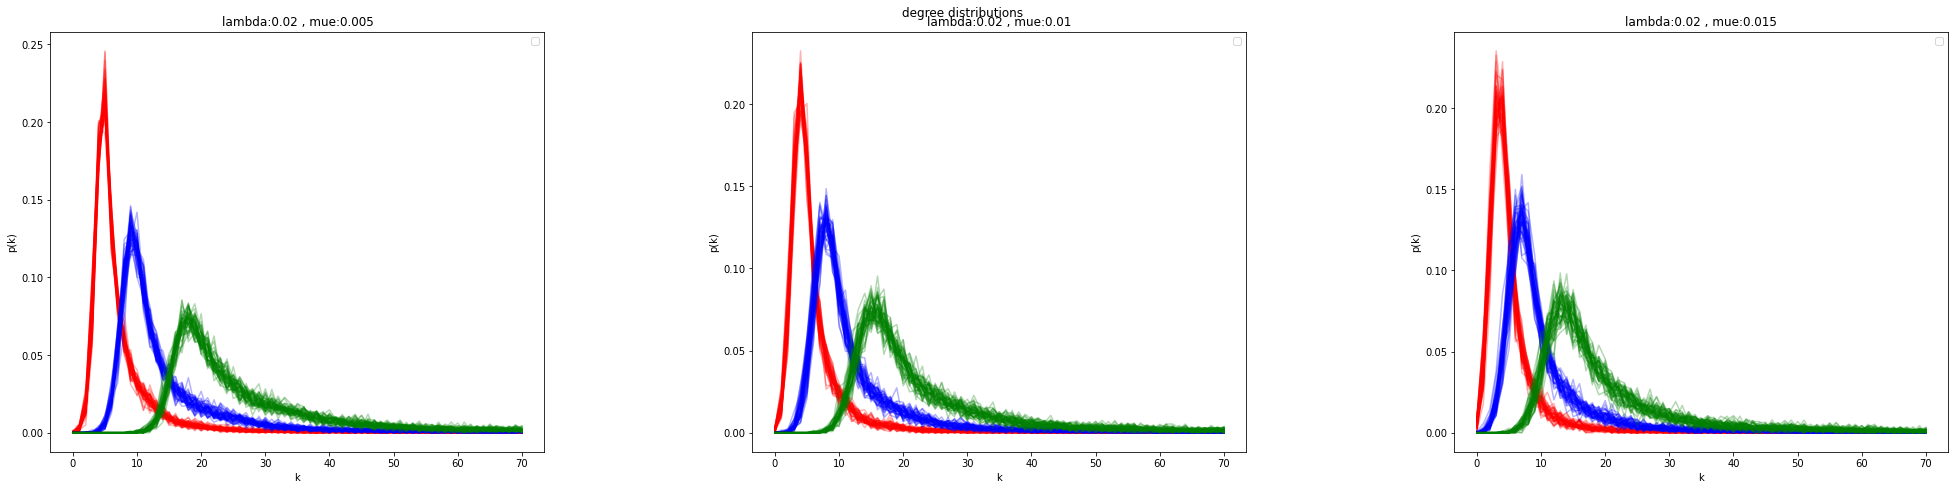

In [ ]:
onoff_scenario_F([G_SF_1, G_SF_2, G_SF_3], snp_times_f, 2*10**4+100, landa2, [mue_1, mue_2, mue_3])

<ipython-input-248-5615892cde98>:19: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  ax[i].legend(loc='top right')


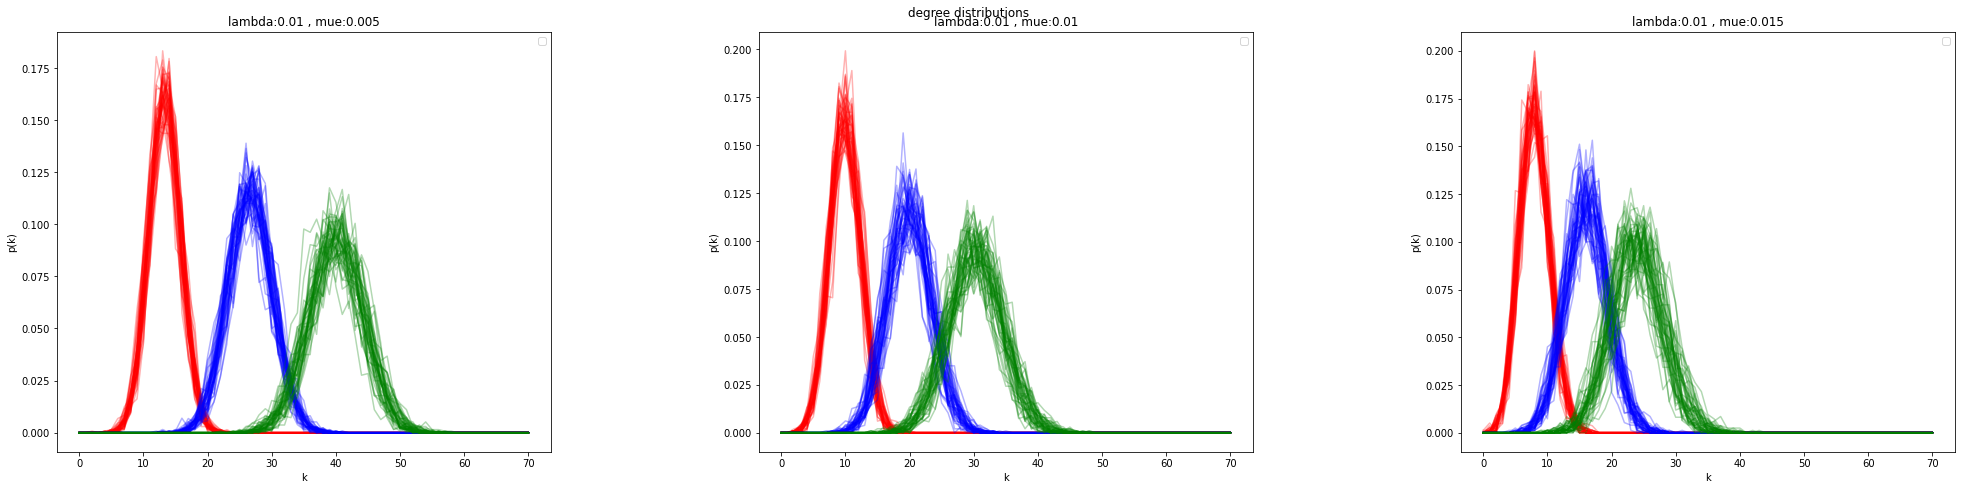

In [ ]:
onoff_scenario_F([G_SW_1, G_SW_2, G_SW_3], snp_times_f, 2*10**4+100, landa1, [mue_1, mue_2, mue_3])

<ipython-input-248-5615892cde98>:19: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  ax[i].legend(loc='top right')


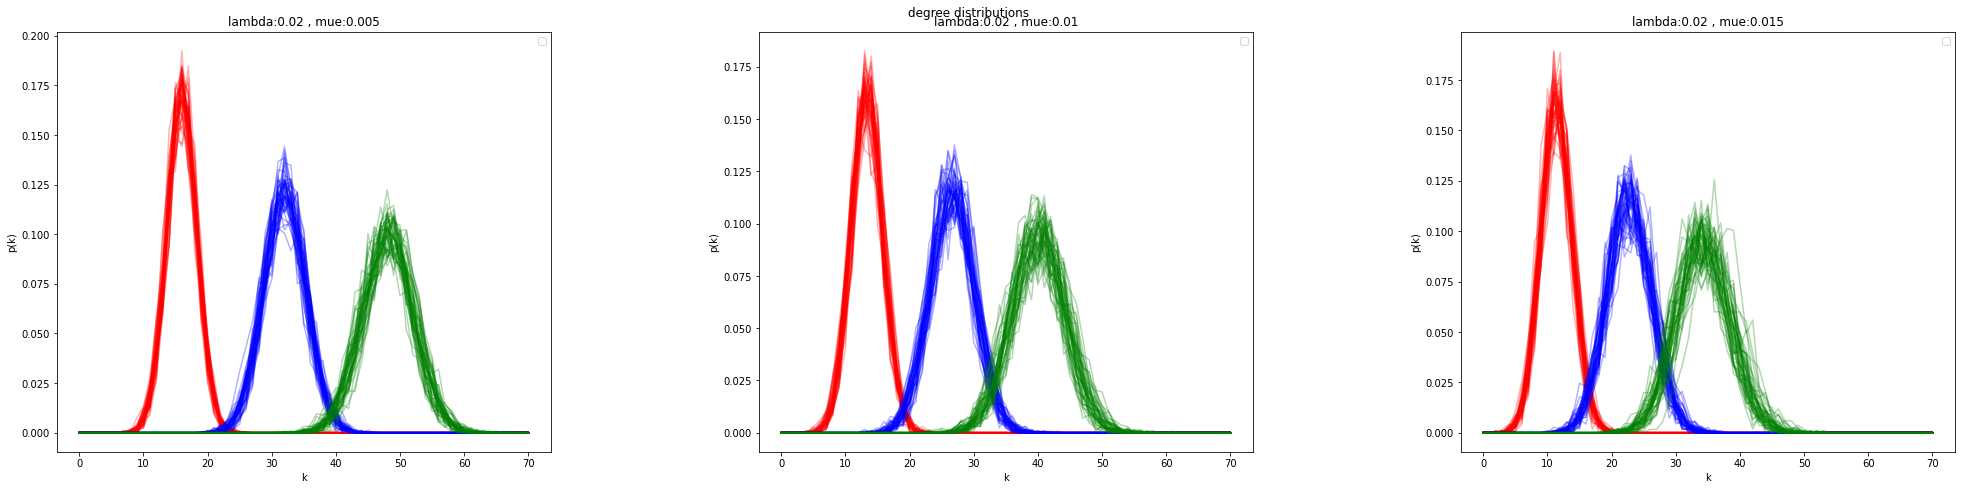

In [ ]:
onoff_scenario_F([G_SW_1, G_SW_2, G_SW_3], snp_times_f, 2*10**4+100, landa2, [mue_1, mue_2, mue_3])

# q-degree

In [ ]:
def find_q_degree(G):
  paths = dict(nx.all_pairs_shortest_path_length(G))
  return max([[max(v1.values())] for v1 in list(paths.values())])[0]

In [ ]:
def custom_plot(x, y, title, xlbl, ylbl):

  plt.figure(figsize=(12, 8))

  plt.plot(x, y, marker='o')
  plt.title(title)
  plt.grid()
  plt.xticks(x)
  # plt.xticks(x, fontsize=8)
  # plt.yticks(np.arange(np.min(y), np.max(y) + 1, 1))
  # plt.yticks(fontsize=5)
  plt.yticks(y)
  plt.xlabel(xlbl)
  plt.ylabel(ylbl)
  plt.tick_params(labelrotation=45)
  # plt.xscale("log")

  plt.show()

In [207]:
n_q = 100

mue1_q = 0.005
mue2_q = 0.015

landa1_q = 0.005
landa2_q = 0.015

sim_duration_q = 2100

snapshot_times = [0, 20, 50, 100] + [200 * i for i in range(1,11)]
snaps_num = len(snapshot_times)
print(str(snaps_num) + ' snapshots, at times:', snapshot_times)

14 snapshots, at times: [0, 20, 50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]


In [259]:
param_title = 'mue: '+str(mue2_q)+', lambda: '+str(landa1_q)
on_durations = [poisson_process(mue2_q, sim_duration_q) for i in range(n_q)]
off_durations = [poisson_process(landa1_q, sim_duration_q) for i in range(n_q)]

on_t, off_t = onoff_data_generator(on_durations, off_durations, max_time=sim_duration_q)

## WS

In [260]:
k_q = 15
p_ws_q = 0.2
G_WS_q = nx.watts_strogatz_graph(n_q, k_q, p_ws_q)    # small-world

In [ ]:
# plot_degree_distribution(G_WS_q, 'WS')

In [261]:
WS_s = Simulation().create(G_WS_q).with_node_onoff_process(on_t, off_t)
_, WS_snaps = WS_s.run(snapshot_times)

In [ ]:
# # all deg dist
# for s in WS_snaps:
#   plot_degree_distribution(s.G, 'WS at '+str(s.time))

snapshot_times:  [0, 20, 50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
q list:  [4, 4, 4, 6, 6, 5, 5, 7, 7, 6, 9, 5, 5, 6]
n list:  [100, 76, 56, 40, 24, 25, 33, 27, 30, 23, 26, 20, 27, 28]


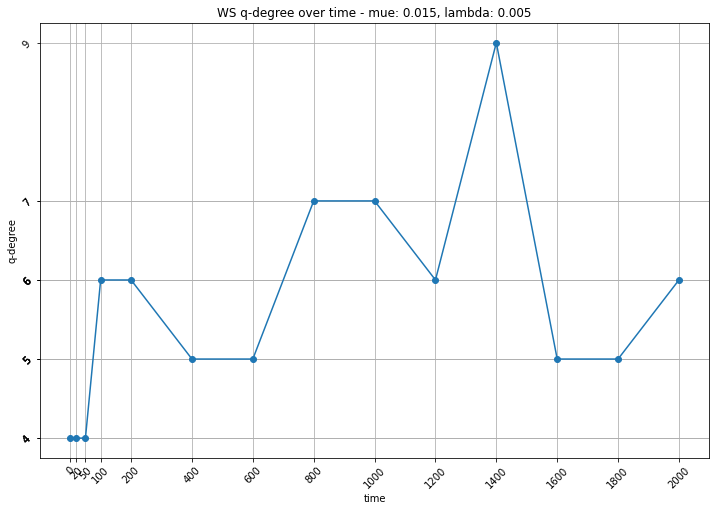

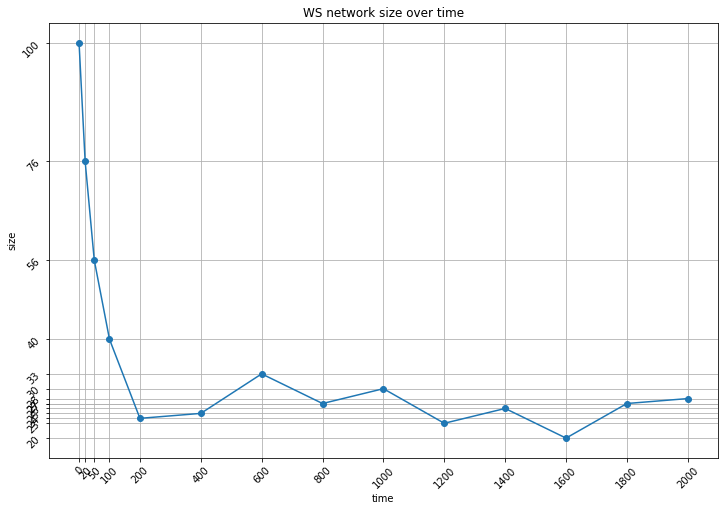

In [262]:
q_list = [None for i in range(snaps_num)]
n_list = [None for i in range(snaps_num)]
for i in range(snaps_num):
  q_list[i] = find_q_degree(WS_snaps[i].G)
  n_list[i] = WS_snaps[i].G.number_of_nodes()

print('snapshot_times: ', snapshot_times)
print('q list: ', q_list)
print('n list: ', n_list)

x = snapshot_times
y = q_list
title = 'WS q-degree over time - ' + param_title
custom_plot(x, y, title, 'time', 'q-degree')

x = snapshot_times
y = n_list
title = 'WS network size over time'
custom_plot(x, y, title, 'time', 'size')

## BA

In [271]:
m_q = 4
G_BA_q = nx.barabasi_albert_graph(n_q, m_q)           # scale-free

In [ ]:
# plot_degree_distribution(G_BA_q, 'BA')

In [269]:
BA_s = Simulation().create(G_BA_q).with_node_onoff_process(on_t, off_t)
_, BA_snaps = BA_s.run(snapshot_times)

snapshot_times:  [0, 20, 50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
q list:  [4, 5, 5, 6, 5, 6, 5, 7, 9, 8, 6, 3, 5, 7]
n list:  [100, 76, 56, 40, 24, 25, 33, 27, 30, 23, 26, 20, 27, 28]


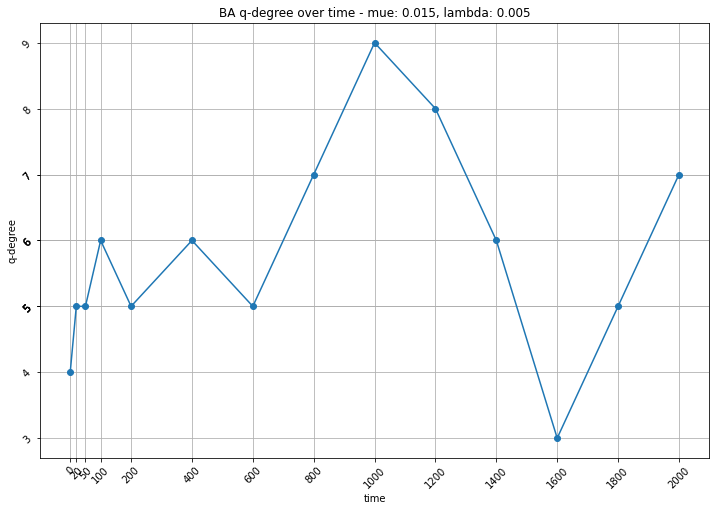

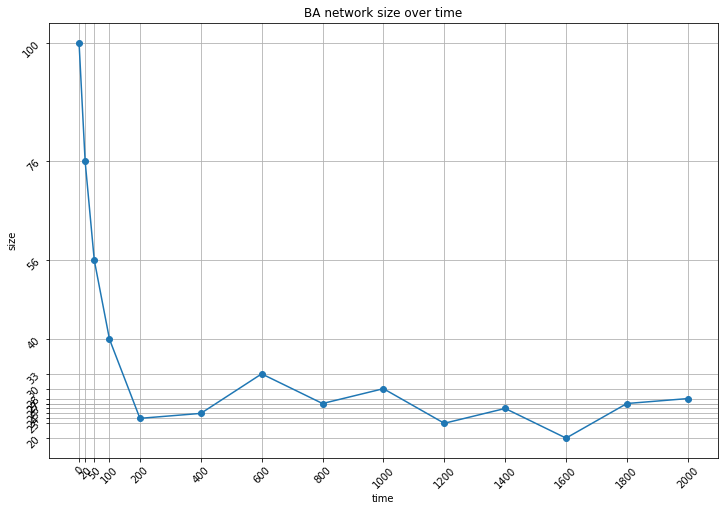

In [272]:
q_list = [None for i in range(snaps_num)]
n_list = [None for i in range(snaps_num)]
for i in range(snaps_num):
  q_list[i] = find_q_degree(BA_snaps[i].G)
  n_list[i] = BA_snaps[i].G.number_of_nodes()

print('snapshot_times: ', snapshot_times)
print('q list: ', q_list)
print('n list: ', n_list)

x = snapshot_times
y = q_list
title = 'BA q-degree over time - ' + param_title
custom_plot(x, y, title, 'time', 'q-degree')

x = snapshot_times
y = n_list
title = 'BA network size over time'
custom_plot(x, y, title, 'time', 'size')

## ER

In [279]:
p_er_q = 0.2
G_ER_q = nx.erdos_renyi_graph(n_q, p_er_q)            # random

In [ ]:
# plot_degree_distribution(G_ER_q, 'ER')

In [280]:
ER_s = Simulation().create(G_ER_q).with_node_onoff_process(on_t, off_t)
_, ER_snaps = ER_s.run(snapshot_times)

snapshot_times:  [0, 20, 50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
q list:  [3, 3, 3, 3, 4, 5, 4, 4, 3, 4, 4, 5, 4, 4]
n list:  [100, 76, 56, 40, 24, 25, 33, 27, 30, 23, 26, 20, 27, 28]


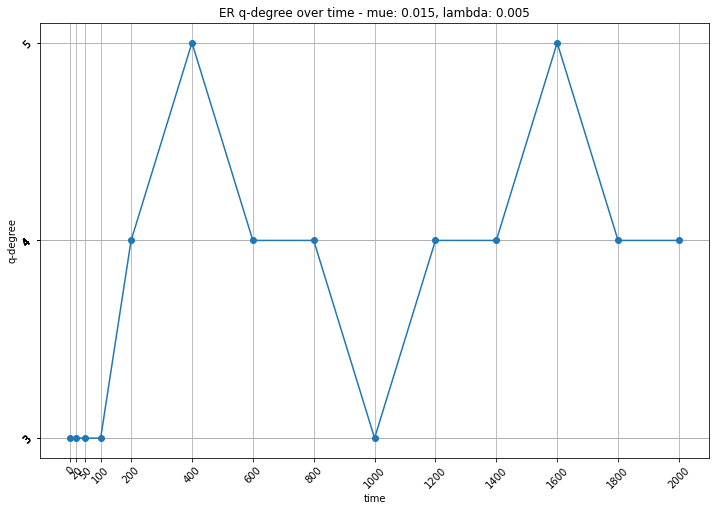

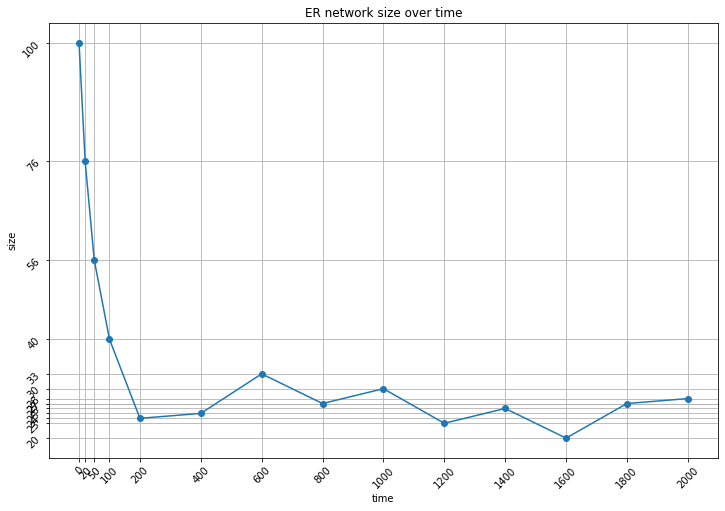

In [281]:
q_list = [None for i in range(snaps_num)]
n_list = [None for i in range(snaps_num)]
for i in range(snaps_num):
  q_list[i] = find_q_degree(ER_snaps[i].G)
  n_list[i] = ER_snaps[i].G.number_of_nodes()

print('snapshot_times: ', snapshot_times)
print('q list: ', q_list)
print('n list: ', n_list)

x = snapshot_times
y = q_list
title = 'ER q-degree over time - ' + param_title
custom_plot(x, y, title, 'time', 'q-degree')

x = snapshot_times
y = n_list
title = 'ER network size over time'
custom_plot(x, y, title, 'time', 'size')